# AI 모델 기반 전력 분석 공격 시연


### 모듈 임포트

In [33]:
import random

import matplotlib.pyplot as plt
import numpy as np
import torch
from sklearn.preprocessing import StandardScaler

from torch.nn import functional as F

import experiments
import models

plt.rcParams["figure.figsize"] = (14, 8)
plt.rcParams['lines.linewidth'] = 0.2
plt.rcParams['text.color'] = 'white'
plt.rcParams['ytick.color'] = 'white'
plt.rcParams['axes.labelcolor'] = 'white'
plt.rcParams['xtick.color'] = 'white'

### 실험 환경 설정

In [34]:
class ARDUINO:
    PORT = 'COM3'
    TIMEOUT = 3


class TRACE:
    DEVICE = 'DPO4032'
    TRIGGER_THRESHOLD = 0.3
    SIZE = 35000
    SCALER = StandardScaler()



### 실험 환경 및 모델 초기화

In [35]:
scope = experiments.ScopeManager()
arduino = experiments.ArduinoProtocol(port=ARDUINO.PORT, timeout=ARDUINO.TIMEOUT)
arduino.close()

net = models.CNNModel()
net.load_state_dict(torch.load('./model/CNN.params'))

<All keys matched successfully>

### 평문 및 암호키 지정

In [36]:
PLAIN = bytes([0, 47, 19, 248, 187, 17, 206, 228, 199, 250, 169, 221, 101, 114, 163, 231])
KEY = bytes([random.randint(0, 255)] * 16)

print(f'키 {KEY[0]}으로 초기화.')

키 177으로 초기화.


### 전력 파형 취득

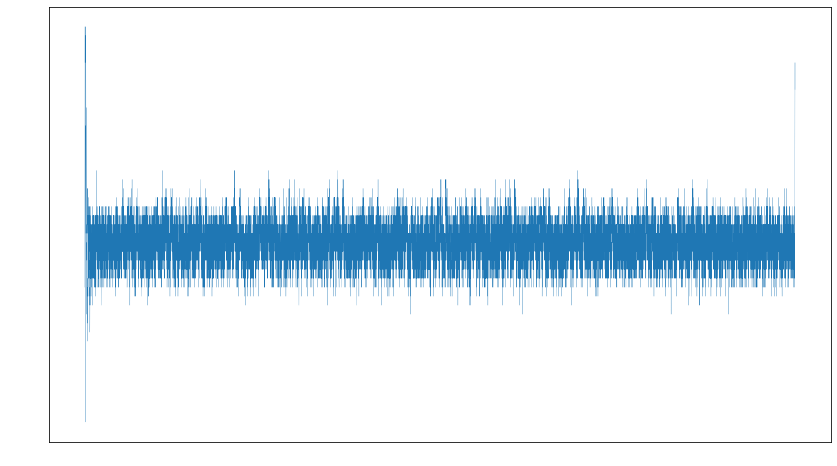

In [37]:
arduino.connect()

arduino.initialize(PLAIN, KEY)
arduino.encrypt()

(main_volt, main_time), (trigger_volt, trigger_time) = scope.get_data(['CH1', 'CH2'])

arduino.wait_encrypt_end()

result = arduino.finalize()

arduino.close()

trace = main_volt[trigger_volt > TRACE.TRIGGER_THRESHOLD].astype(np.float32)
cipher = np.frombuffer(result, dtype=np.uint8)
key = np.frombuffer(KEY, dtype=np.uint8)

plt.plot(trace)
plt.show()

### 전력 파형 전처리

In [38]:
if trace.size < TRACE.SIZE:
    trace = np.pad(trace, (0, TRACE.SIZE - trace.size), constant_values=0)
else:
    trace = trace[:TRACE.SIZE]

trace = TRACE.SCALER.fit_transform(trace.reshape(-1, 1)).flatten()

trace = np.expand_dims(trace, 0)

# key = np.eye(256, dtype=np.uint8)[key[0]]
key = key[0].astype('int64')

### AI 모델을 이용한 암호키 추정

In [39]:
tensor = torch.Tensor(trace).unsqueeze(dim=1)
result = net.forward(tensor)
result = F.softmax(result, dim=1)
predict = torch.argmax(result)

print(f'추정한 암호키: {predict}')
print(f'실제 암호키: {key}')

추정한 암호키: 177
실제 암호키: 177


### 키의 추정 확률 분포 시각화

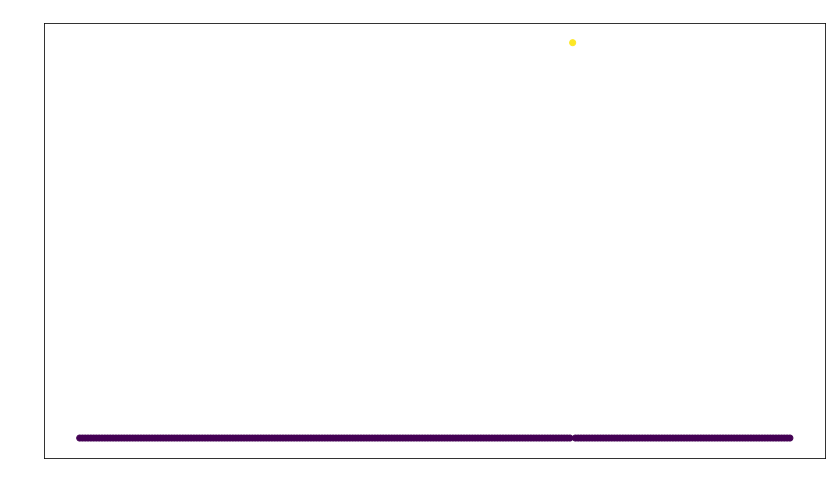

In [40]:
res_np = result.detach().numpy()

plt.title('predict')
plt.xlabel('byte key'), plt.ylabel('probability')
plt.scatter(range(256), res_np, c=res_np)

plt.show()